<a href="https://colab.research.google.com/github/miltiadiss/Decision-Theory/blob/main/TSLA_stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
desired_directory = '/content/drive/MyDrive/alphavantage' #define current directory in google drive
os.chdir(desired_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import requests

#API_KEY = YZFYJ9DASTWXPXOS
#STOCK_SYMBOL = TSLA

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=TSLA&outputsize=full&apikey=YZFYJ9DASTWXPXOS'
r = requests.get(url)
json_data = r.json()

#print(json_data)

Data saved to close_prices.csv


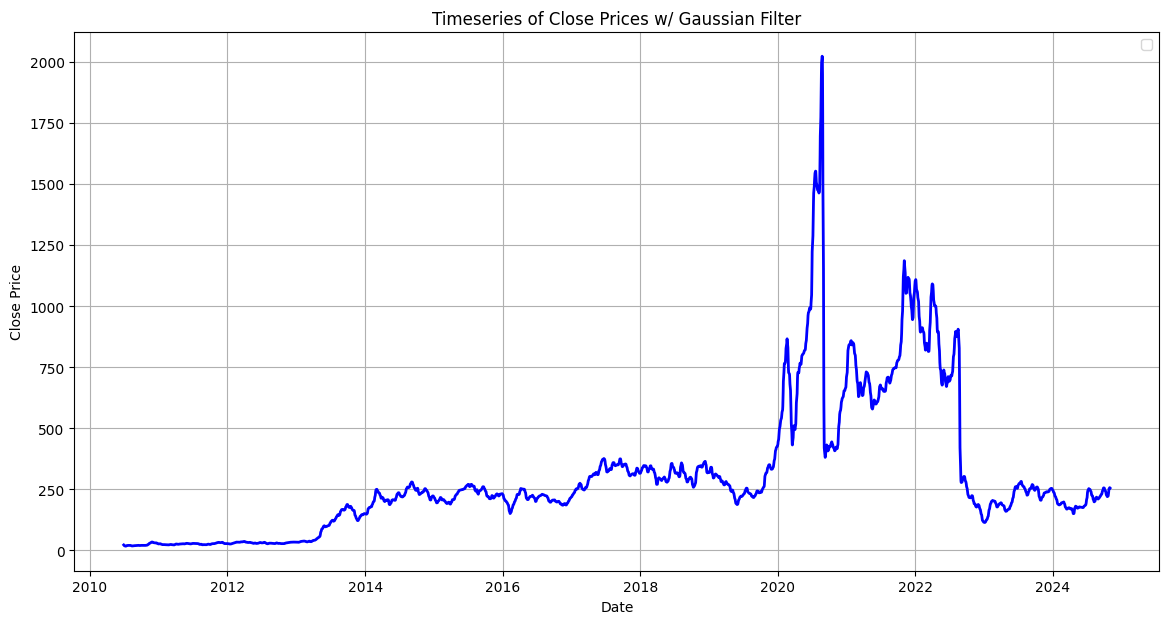

In [4]:
import json
import csv
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import numpy as np
import matplotlib.pyplot as plt

# Extract "Time Series (Daily)" part from JSON
time_series = json_data.get("Time Series (Daily)", {})

# Prepare data for CSV
csv_data = [("Date", "Close")]  # Header for CSV file

# Loop through each date and get the "close" price
for date, daily_data in time_series.items():
    close_price = daily_data.get("4. close", None)
    if close_price:
        csv_data.append((date, close_price))

# Write data to CSV file
csv_file = 'close_prices.csv'
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Data saved to {csv_file}")

# Read CSV file and store the data in a DataFrame
df = pd.read_csv('close_prices.csv', parse_dates=['Date'])
df = df.sort_values(by='Date')  # Sorting by 'Date'

# Apply Gaussian Filter in 'Close' prices for smoothing
sigma = 2
df['Close'] = gaussian_filter1d(df['Close'], sigma=sigma)

# Plot the smoothed timeseries
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=2)

plt.title('Timeseries of Close Prices w/ Gaussian Filter')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

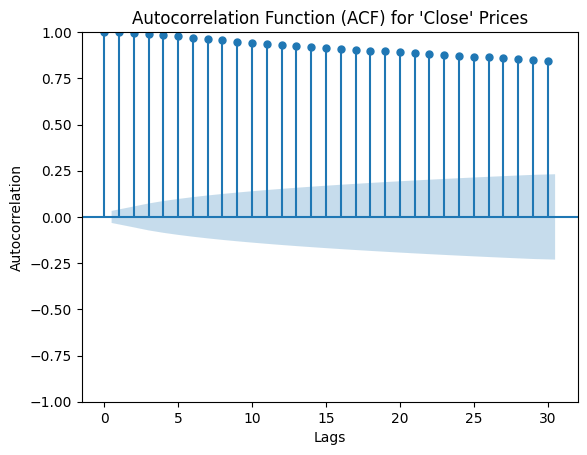

In [5]:
from statsmodels.graphics.tsaplots import plot_acf

# Create ACF plot to find related lags
plot_acf(df['Close'], lags=30)
plt.title("Autocorrelation Function (ACF) for 'Close' Prices")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation")
plt.show()

Training and Validation


Model Parameters for N=1:
Bias: 0.4632
Weight for close_t-1: 0.9987
Model Equation:
Close_t = 0.4632 + (0.9987) * close_t-1

Model Parameters for N=2:
Bias: 0.6831
Weight for close_t-1: 1.9376
Weight for close_t-2: -0.9398
Model Equation:
Close_t = 0.6831 + (1.9376) * close_t-1 + (-0.9398) * close_t-2

Model Parameters for N=3:
Bias: 0.0881
Weight for close_t-1: 2.7735
Weight for close_t-2: -2.6630
Weight for close_t-3: 0.8892
Model Equation:
Close_t = 0.0881 + (2.7735) * close_t-1 + (-2.6630) * close_t-2 + (0.8892) * close_t-3

Model Parameters for N=4:
Bias: 0.1380
Weight for close_t-1: 3.4860
Weight for close_t-2: -4.7965
Weight for close_t-3: 3.1111
Weight for close_t-4: -0.8010
Model Equation:
Close_t = 0.1380 + (3.4860) * close_t-1 + (-4.7965) * close_t-2 + (3.1111) * close_t-3 + (-0.8010) * close_t-4

Model Parameters for N=5:
Bias: 0.0324
Weight for close_t-1: 4.1240
Weight for close_t-2: -7.2745
Weight for close_t-3: 6.9312
Weight for close_t-4: -3.5773
Weight for close_t-5: 

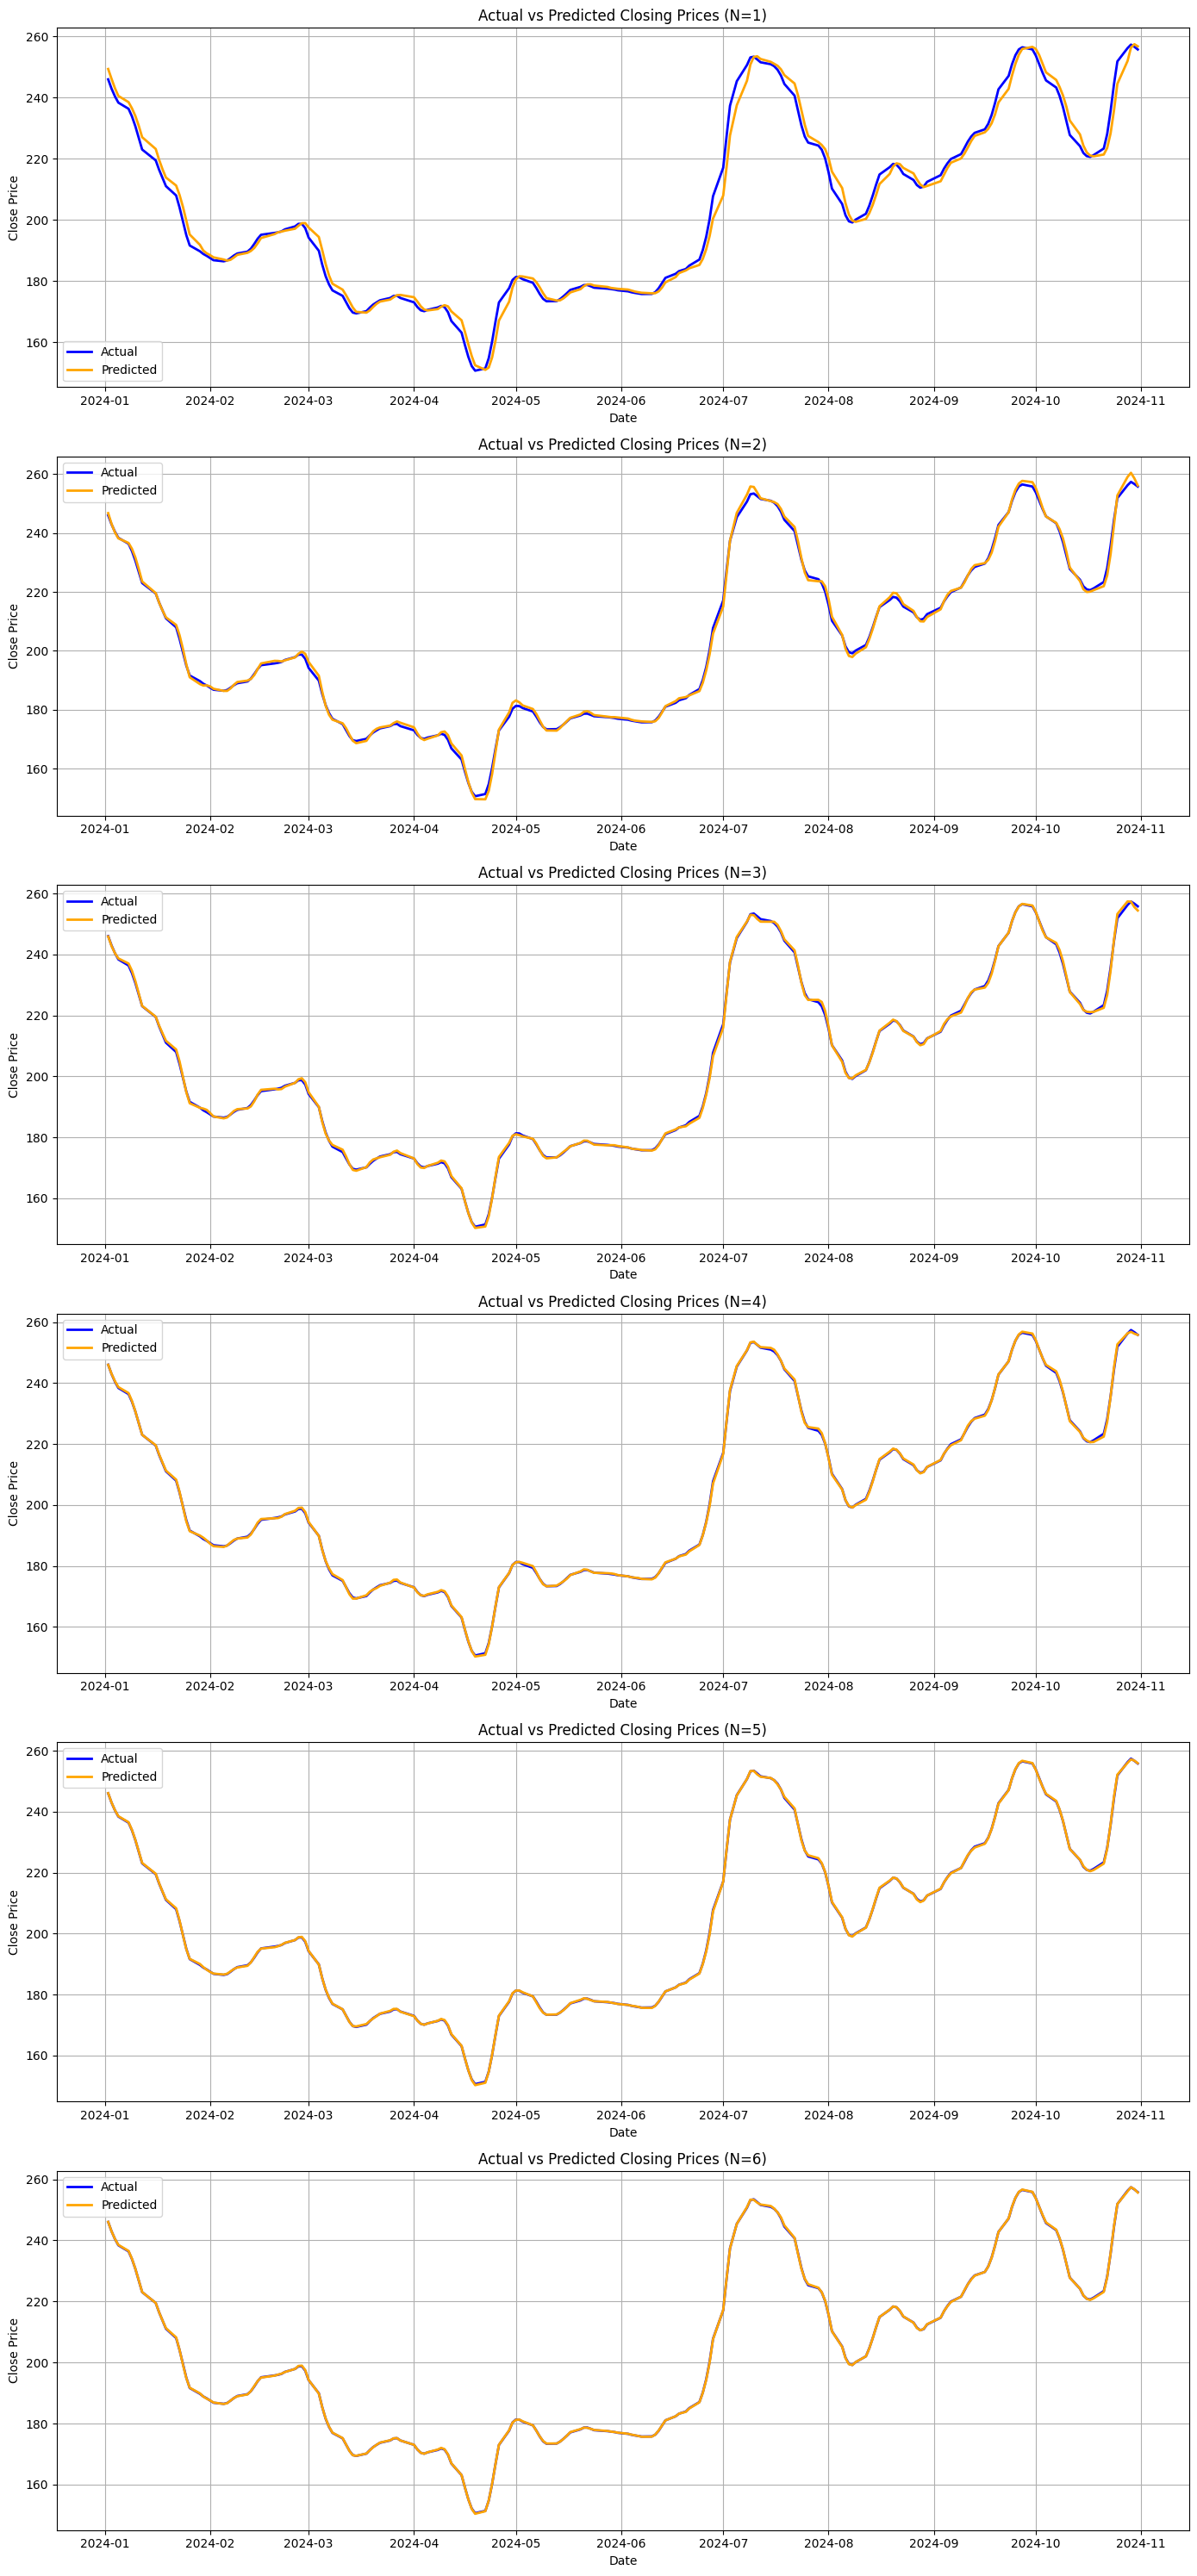

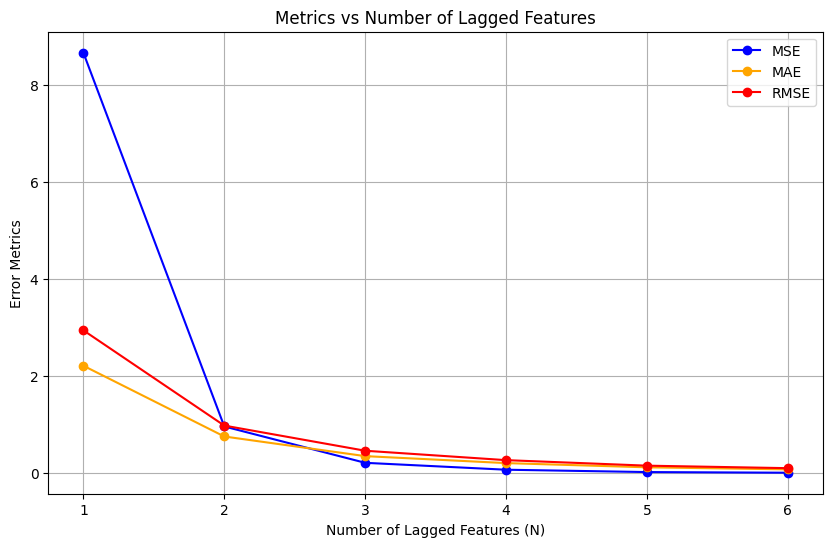

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def linear_regression_model(N, data):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    # Create and fit the Linear Regression model using the training set
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make the prediction using the validation set
    y_pred = model.predict(X_val)

    # Evaluate the model metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mse = mean_squared_error(y_val, y_pred)

    # Get model parameters (weights and bias)
    weights = model.coef_
    bias = model.intercept_

    return mae, rmse, mse, y_val, y_pred, validation_data['Date'], weights, bias

# Plot the actual and predicted 'close' prices for the different values of lagged features and
# the initial DataFrame
num_tests = 6  # Testing from N = 1 to 6
fig, axes = plt.subplots(num_tests, 1, figsize=(14, 5 * num_tests))
results = []

for idx, N in enumerate(range(1, num_tests + 1)):
    mae, rmse, mse, y_val, y_pred, dates, weights, bias = linear_regression_model(N, df)  # Call the function here
    results.append((N, mae, rmse, mse))

    axes[idx].plot(dates, y_val, label='Actual', color='blue', linewidth=2)
    axes[idx].plot(dates, y_pred, label='Predicted', color='orange', linewidth=2)
    axes[idx].set_title(f'Actual vs Predicted Closing Prices (N={N})')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Close Price')
    axes[idx].legend()
    axes[idx].grid(True)

    # Print the model coefficients
    print(f"\nModel Parameters for N={N}:")
    print(f"Bias: {bias:.4f}")
    equation = f"Close_t = {bias:.4f}"
    for i, coef in enumerate(weights):
        equation += f" + ({coef:.4f}) * close_t-{i+1}"
        print(f"Weight for close_t-{i+1}: {coef:.4f}")
    print("Model Equation:")
    print(equation)

results_df = pd.DataFrame(results, columns=['N', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error'])
print('\nMetrics')
print(results_df)

plt.tight_layout()
plt.show()

# Plot Metrics vs Number of Lagged Features
plt.figure(figsize=(10, 6))
mse_values = results_df['Mean Squared Error']
mae_values = results_df['Mean Absolute Error']
rmse_values = results_df['Root Mean Squared Error']

plt.plot(range(1, num_tests + 1), mse_values, marker='o', linestyle='-', color='blue', label='MSE')
plt.plot(range(1, num_tests + 1), mae_values, marker='o', linestyle='-', color='orange', label='MAE')
plt.plot(range(1, num_tests + 1), rmse_values, marker='o', linestyle='-', color='red', label='RMSE')

plt.title('Metrics vs Number of Lagged Features')
plt.xlabel('Number of Lagged Features (N)')
plt.ylabel('Error Metrics')
plt.xticks(range(1, num_tests + 1))
plt.legend()
plt.grid(True)
plt.show()

         Date  Predicted Close
0  2024-11-01       255.615679
1  2024-11-02       255.985932
2  2024-11-03       256.325082
3  2024-11-04       256.490744
4  2024-11-05       257.058198
5  2024-11-06       258.854364
6  2024-11-07       262.206983
7  2024-11-08       266.578511
8  2024-11-09       270.880630
9  2024-11-10       274.182993
10 2024-11-11       276.237760
11 2024-11-12       277.447223
12 2024-11-13       278.384112
13 2024-11-14       279.310985
14 2024-11-15       280.080715
15 2024-11-16       280.434400
16 2024-11-17       280.380181
17 2024-11-18       280.305147
18 2024-11-19       280.734086
19 2024-11-20       281.955287
20 2024-11-21       283.827735
21 2024-11-22       285.910675
22 2024-11-23       287.785549
23 2024-11-24       289.302834
24 2024-11-25       290.579198
25 2024-11-26       291.792126
26 2024-11-27       292.974794
27 2024-11-28       293.984985
28 2024-11-29       294.653649
29 2024-11-30       294.965693


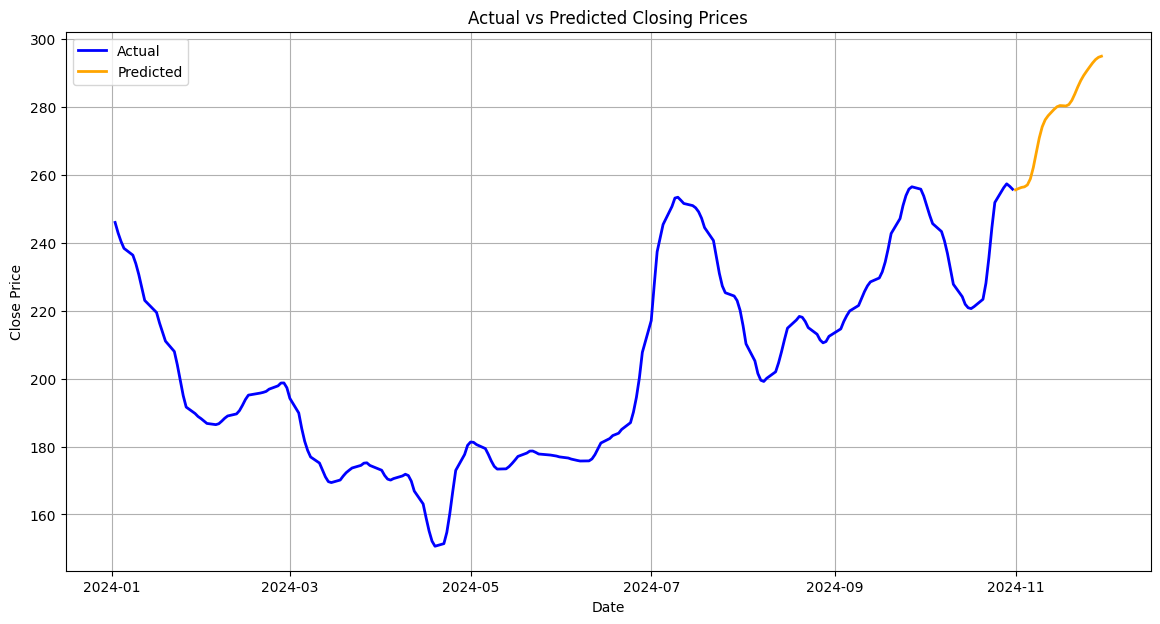

<Figure size 640x480 with 0 Axes>

In [48]:
# Function to predict close prices for a given interval
def predict_close_price(df, weights, bias, start_date, num_days):
    predictions = []
    last_known_dates = df['Date'].values # Last known dates
    last_known_prices = df['Close'].values # Last known 'close' prices

    # Get the last N close prices for initial prediction
    last_n_prices = last_known_prices[-N:]

    for _ in range(num_days):
        # Calculate predicted close price for the next day
        predicted_close = np.dot(last_n_prices[::-1], weights) + bias
        predictions.append(predicted_close)

        # Update the last N prices for the next prediction
        last_n_prices = np.append(last_n_prices[1:], predicted_close)  # Shift prices

    return predictions

# Train the model with the best value of lagged features, which is N=6
N = 6
_, _, _, _, _, _, weights, bias = linear_regression_model(N, df)

# Make predictions for November 2024 starting from '2024-11-01'
start_date = '2024-11-01'
num_days = 30
predicted_prices = predict_close_price(df, weights, bias, start_date, num_days)

# Create a DataFrame for predicted prices with corresponding dates
predicted_dates = [pd.to_datetime(start_date) + pd.Timedelta(days=i) for i in range(num_days)]
predictions_df = pd.DataFrame({'Date': predicted_dates, 'Predicted Close': predicted_prices})
print(predictions_df)

# Filter to keep only predictions for the year 2024
predictions_df = predictions_df[predictions_df['Date'].dt.year == 2024]

# Combine predictions with the initial DataFrame
df_combined = pd.concat([df, predictions_df], ignore_index=True)

# Plot the actual and predicted 'close' prices for November 2024
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(df[df['Date'].dt.year == 2024]['Date'], df[df['Date'].dt.year == 2024]['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(predictions_df['Date'], predictions_df['Predicted Close'], label='Predicted', color='orange', linestyle='-', linewidth=2)
ax.set_title('Actual vs Predicted Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price')
ax.legend()
ax.grid(True)
plt.show()

plt.tight_layout()
plt.show()

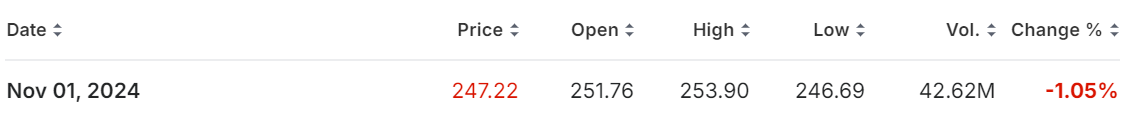

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.470e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


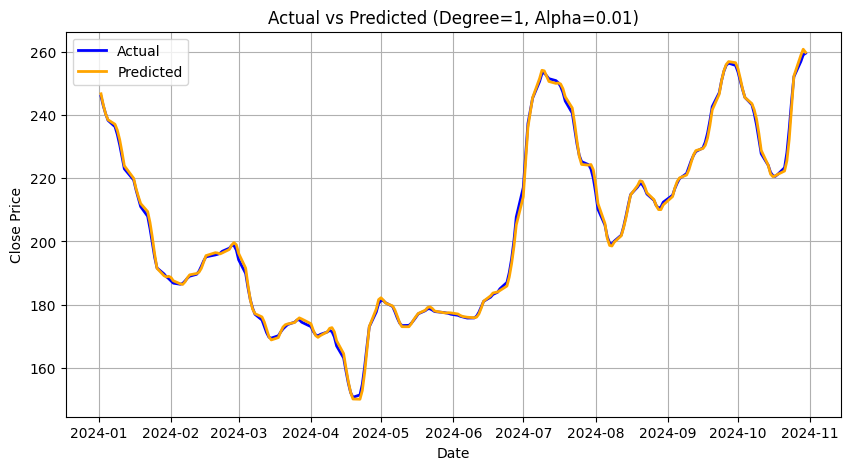

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


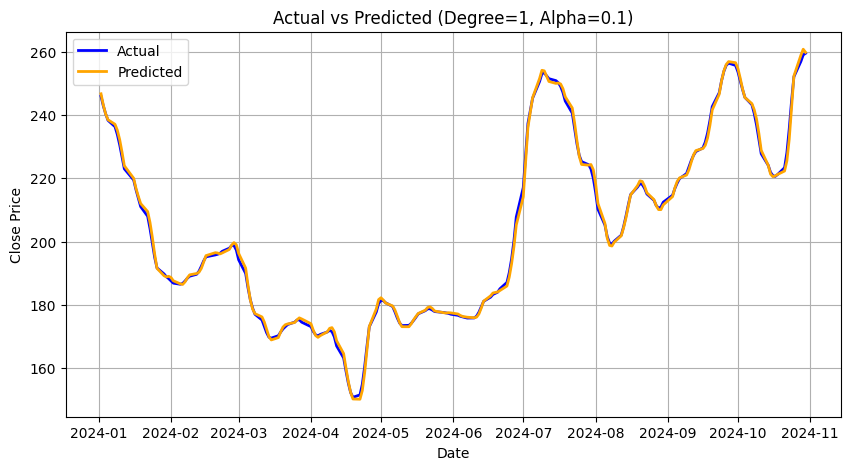

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.402e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


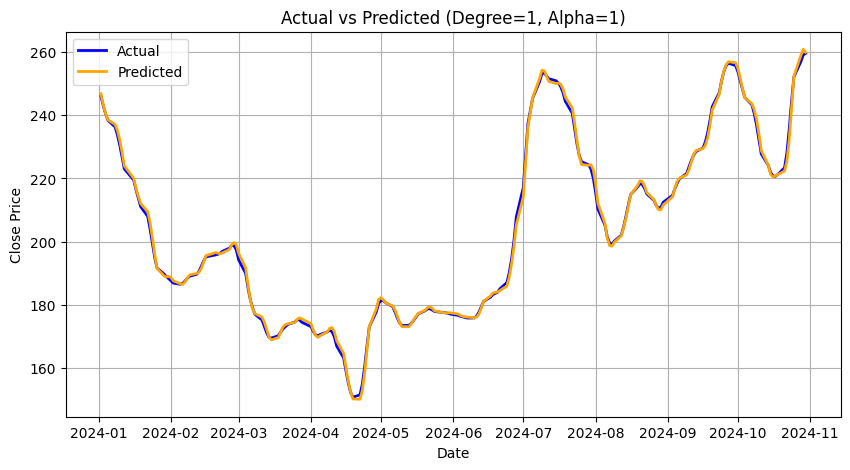

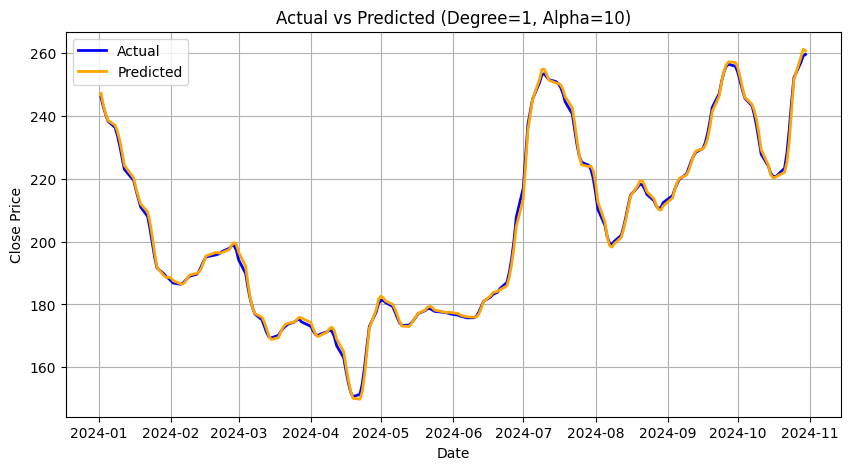

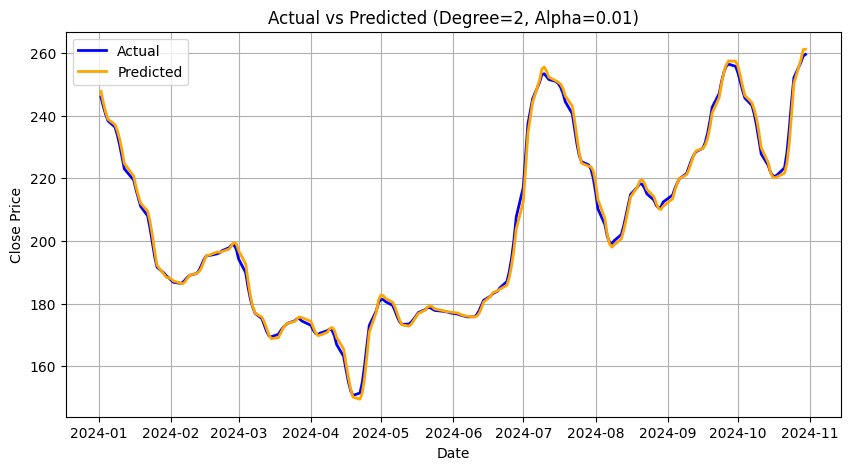

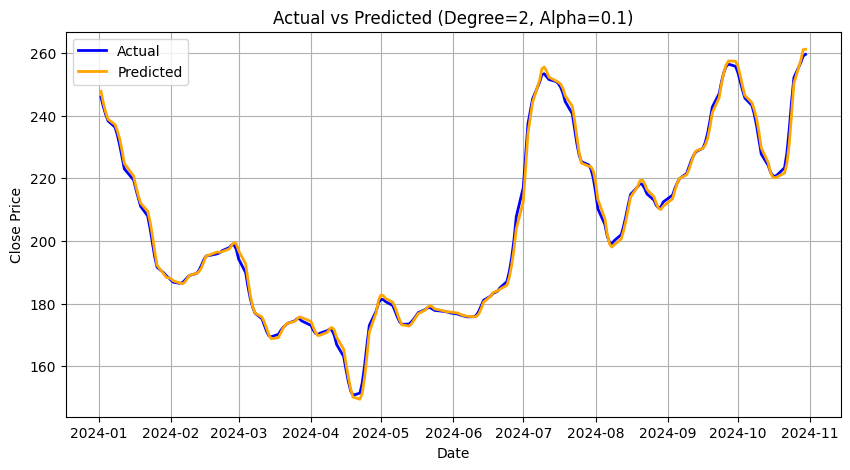

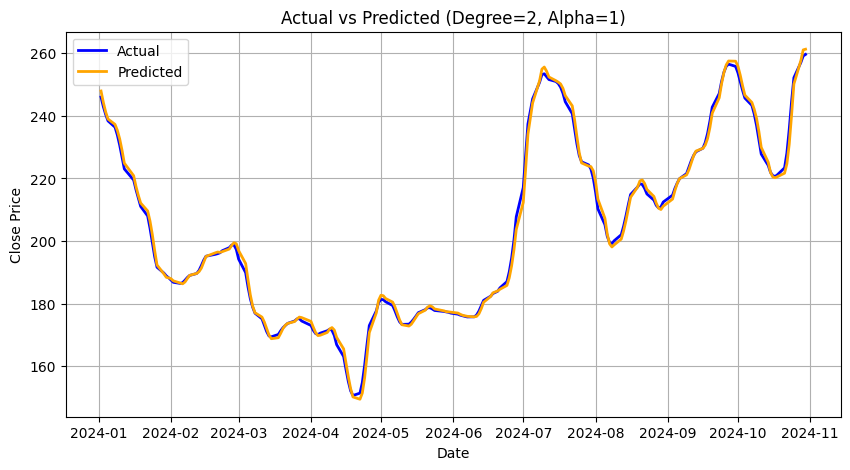

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.654e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


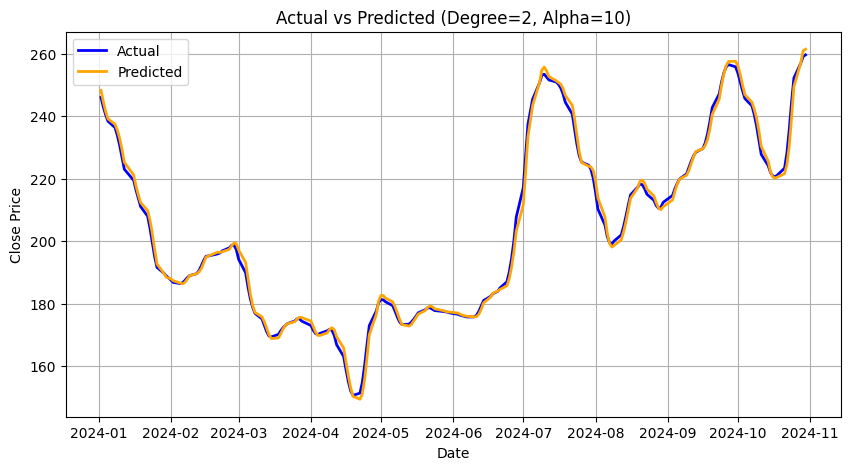

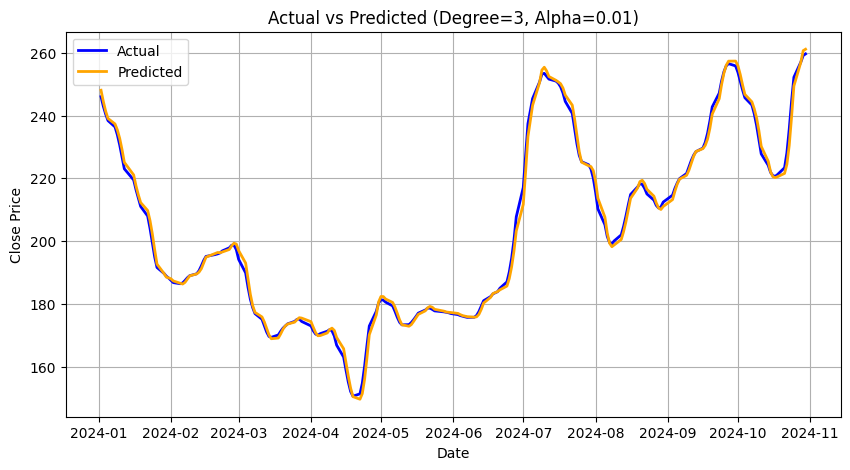

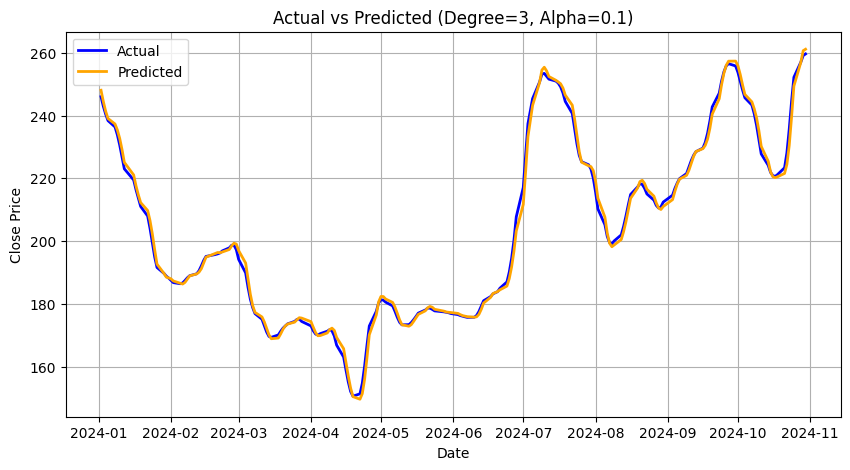

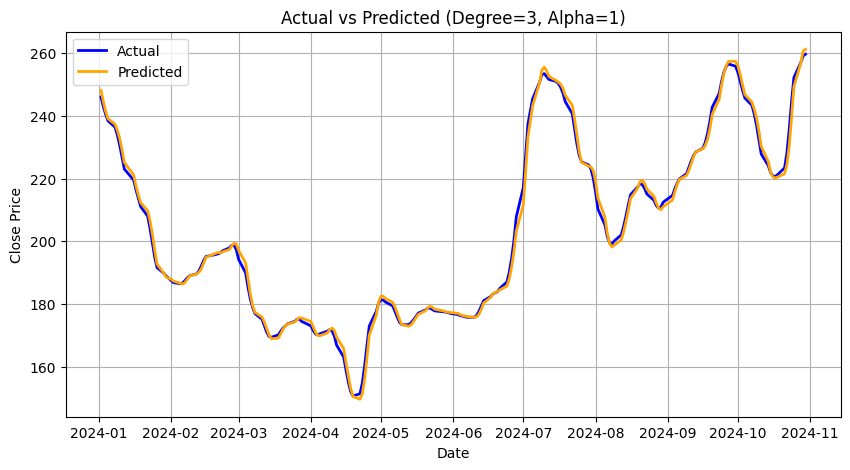

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.281e+04, tolerance: 2.792e+04
  model = cd_fast.enet_coordinate_descent(


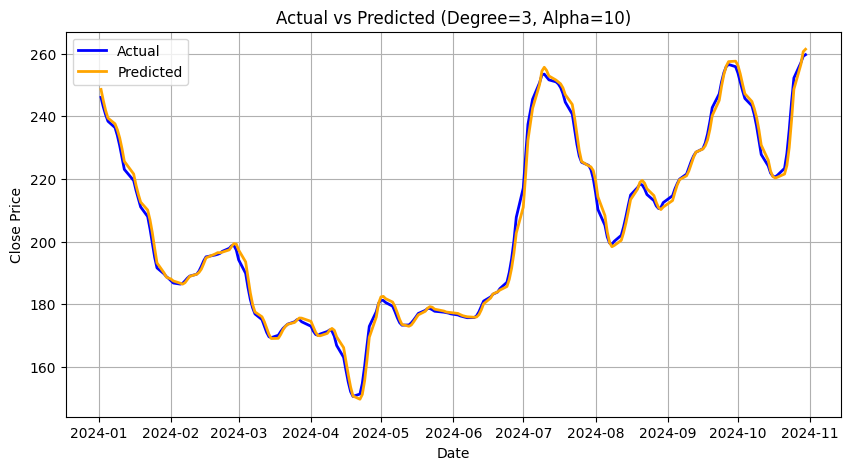

    Model  Degree  Alpha       MSE
0   Lasso       1   0.01  0.941846
1   Lasso       1   0.10  0.944152
2   Lasso       1   1.00  0.967836
3   Lasso       1  10.00  1.345622
4   Lasso       2   0.01  2.113771
5   Lasso       2   0.10  2.129408
6   Lasso       2   1.00  2.283821
7   Lasso       2  10.00  2.965068
8   Lasso       3   0.01  2.726361
9   Lasso       3   0.10  2.740071
10  Lasso       3   1.00  2.864402
11  Lasso       3  10.00  3.701312


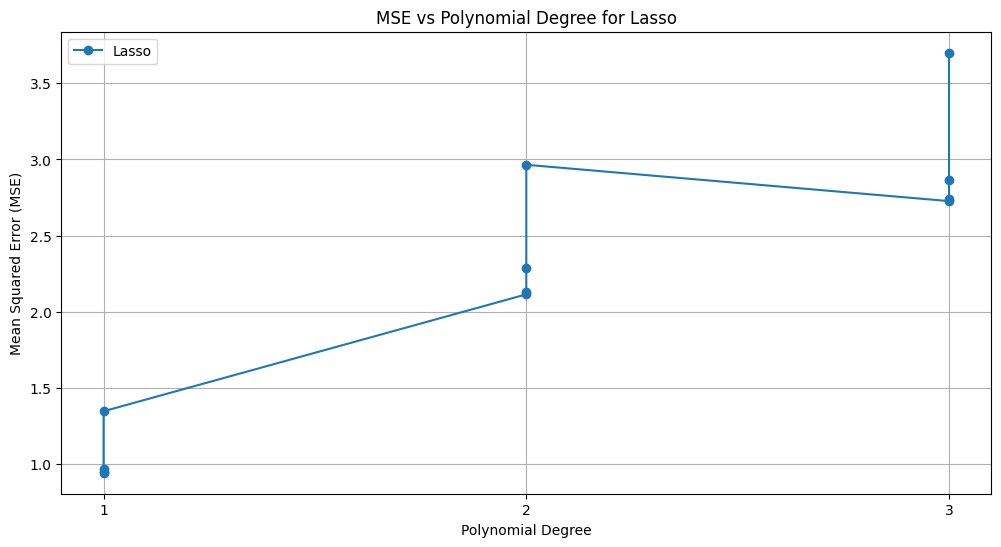

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create a function that trains and evaluates the model for different amounts
# of lagged features and different DataFrames
def L1_polynomial_regression_model(N, data, max_degree=3, alpha_values=[0.01, 0.1, 1, 10]):
    # Create N lagged features
    for i in range(1, N + 1):
        data[f'close_t-{i}'] = data['Close'].shift(i)

    # Drop NaN values
    data.dropna(inplace=True)

    # Create training set and validation set
    train_data = data[data['Date'] < '2024-01-01']  # Use previous years for training
    validation_data = data[data['Date'] >= '2024-01-01']  # Use year 2024 for validation

    # Prepare features (X) and target (y) for training and validation
    X_train = train_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_train = train_data['Close']
    X_val = validation_data[[f'close_t-{i}' for i in range(1, N + 1)]]
    y_val = validation_data['Close']

    results = []

    # Loop over different polynomial degrees
    for degree in range(1, max_degree + 1):
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_val = poly.transform(X_val)

        # Evaluate Lasso for different alpha values
        for alpha in alpha_values:
            lasso = Lasso(alpha=alpha)
            lasso.fit(X_poly_train, y_train)
            y_pred_lasso = lasso.predict(X_poly_val)
            lasso_mse = mean_squared_error(y_val, y_pred_lasso)
            results.append(('Lasso', degree, alpha, lasso_mse))

            # Plot actual vs predicted for each combination of degree and alpha
            plt.figure(figsize=(10, 5))
            plt.plot(validation_data['Date'], y_val, label='Actual', color='blue', linewidth=2)
            plt.plot(validation_data['Date'], y_pred_lasso, label='Predicted', color='orange', linewidth=2)
            plt.title(f'Actual vs Predicted (Degree={degree}, Alpha={alpha})')
            plt.xlabel('Date')
            plt.ylabel('Close Price')
            plt.legend()
            plt.grid(True)
            plt.show()

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results, columns=['Model', 'Degree', 'Alpha', 'MSE'])
    print(results_df)

    # Plotting the results
    plt.figure(figsize=(12, 6))
    for model in results_df['Model'].unique():
        subset = results_df[results_df['Model'] == model]
        plt.plot(subset['Degree'], subset['MSE'], marker='o', label=model)

    plt.title('MSE vs Polynomial Degree for Lasso')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.xticks(range(1, max_degree + 1))
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
L1_polynomial_regression_model(6, df)  # Call the function with your DataFrame
